In [6]:
import sys
sys.path.append("./attention-module/MODELS")

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from tqdm.notebook import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from cbam import CBAM
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torchvision.models.resnet import BasicBlock


In [8]:
class MACNNLayer(nn.Module):
    def __init__(self, channel_amount):
        super(MACNNLayer, self).__init__()

    def forward(self, x):
        return x


# CBAM from CBAM paper https://arxiv.org/pdf/1807.06521
class ChannelAttention(nn.Module):
    def __init__(self, channel_amount):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.mlp = nn.Sequential(
            nn.Conv2d(channel_amount, channel_amount // 3, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(channel_amount // 3, channel_amount, kernel_size=1)
                                )
        self.sig = nn.Sigmoid()

    def forward(self, x):
        x_avg = self.avg_pool(x)
        x_max = self.max_pool(x)
        mlp_avg = self.mlp(x_avg)
        mlp_max = self.mlp(x_max)
        combine_mlp = mlp_avg + mlp_max
        x_return = self.sig(combine_mlp)
        return x_return * x


class SpatialAttention(nn.Module):
    def __init__(self, channel_amount):
        super(SpatialAttention, self).__init__()
        self.clayer = nn.Conv2d(2, 1, kernel_size=7, padding=3)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        max_x, _ = torch.max(x, 1, keepdim=True)
        mean_x = torch.mean(x, 1, keepdim=True)
        combine = torch.cat([max_x, mean_x], 1)
        return_x = self.sig(self.clayer(combine))
        return x * return_x

class MyCBAM(nn.Module):
    def __init__(self, channel_amount):
        super(MyCBAM, self).__init__()
        self.channel_attention = ChannelAttention(channel_amount)
        self.spatial_attention = SpatialAttention(channel_amount)

    def forward(self, x):
        x = self.channel_attention(x)
        x = self.spatial_attention(x)
        return x
        

In [9]:
# BasicBlock taken from Resnet Paper https://arxiv.org/pdf/1512.03385 (pytorch module)

class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.block_64 = self.make_big_block(64, count=2)
        self.block_128 = self.make_big_block(128, count=2)
        self.block_256 = self.make_non_trans_big_block(256, count=2)


        self.adaptive_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(256, 200)
        self.dropout = nn.Dropout(0.5)

    def make_big_block(self, channel_count, count = 3, kernel_size = 3):
        ordering = []
        downsample = nn.Sequential(
            nn.Conv2d(channel_count, channel_count*2, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(channel_count*2),
        )
        for i in range(count):
            if i != count - 1:
                ordering.append(BasicBlock(channel_count, channel_count))
                ordering.append(MyCBAM(channel_count))
            else:
                ordering.append(BasicBlock(channel_count, channel_count*2, stride=2, downsample=downsample))
                ordering.append(MyCBAM(channel_count*2))

        return nn.Sequential(*ordering)

    def make_non_trans_big_block(self, channel_count, count = 3, kernel_size = 3):
        ordering = []

        for i in range(count):
            ordering.append(BasicBlock(channel_count, channel_count))

        return nn.Sequential(*ordering)


    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.block_64(x)
        x = self.block_128(x)
        x = self.block_256(x)
        x = self.adaptive_pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc1(x)
        return x


size of validation dataset 300


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 0 Training Loss 5.33171608542659. Validation Loss 5.249264761606852 Accuracy 0.3333333333333333


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 1 Training Loss 5.18897291598171. Validation Loss 5.121653683980306 Accuracy 0.6666666666666666


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 2 Training Loss 5.10186745654. Validation Loss 4.995350201924642 Accuracy 1.0


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 3 Training Loss 5.028822334264093. Validation Loss 4.9577539380391435 Accuracy 1.3333333333333333


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 4 Training Loss 4.966519775497817. Validation Loss 4.940146287282308 Accuracy 1.3333333333333333


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 5 Training Loss 4.924102964592181. Validation Loss 4.795438868204752 Accuracy 1.6666666666666667


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 6 Training Loss 4.866340434379564. Validation Loss 4.676713746388753 Accuracy 1.3333333333333333


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 7 Training Loss 4.766431210373509. Validation Loss 4.489001077016194 Accuracy 2.3333333333333335


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 8 Training Loss 4.690349011074504. Validation Loss 4.761418590545654 Accuracy 1.3333333333333333


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 9 Training Loss 4.614731622655056. Validation Loss 4.402937768300374 Accuracy 4.333333333333333


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 10 Training Loss 4.5389224761906615. Validation Loss 4.39943826675415 Accuracy 3.3333333333333335


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 11 Training Loss 4.451458376585328. Validation Loss 4.252080771128337 Accuracy 4.333333333333333


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 12 Training Loss 4.3890329181080245. Validation Loss 4.295487931569418 Accuracy 5.333333333333333


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 13 Training Loss 4.320841173393751. Validation Loss 4.104957777659099 Accuracy 5.666666666666667


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 14 Training Loss 4.2688260215769995. Validation Loss 4.090559295018514 Accuracy 7.333333333333333


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 15 Training Loss 4.204844707767713. Validation Loss 4.167599261601766 Accuracy 7.333333333333333


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 16 Training Loss 4.135166144094678. Validation Loss 4.028706588745117 Accuracy 8.333333333333334


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 17 Training Loss 4.080842399664163. Validation Loss 3.988011868794759 Accuracy 9.0


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 18 Training Loss 4.027914614186691. Validation Loss 3.970943110783895 Accuracy 9.0


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 19 Training Loss 3.960508040055334. Validation Loss 3.9582341702779136 Accuracy 9.666666666666666


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 20 Training Loss 3.8697645361899995. Validation Loss 3.9913593355814614 Accuracy 9.666666666666666


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 21 Training Loss 3.8365858097766465. Validation Loss 3.799852024714152 Accuracy 9.0


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 22 Training Loss 3.7630097186896188. Validation Loss 3.803427670796712 Accuracy 10.333333333333334


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 23 Training Loss 3.71985180293379. Validation Loss 3.6456000137329103 Accuracy 12.666666666666666


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 24 Training Loss 3.665091525306608. Validation Loss 3.5592138799031576 Accuracy 16.333333333333332


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 25 Training Loss 3.5921470124888177. Validation Loss 3.566095813115438 Accuracy 16.0


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 26 Training Loss 3.537505325117068. Validation Loss 3.4439858214060464 Accuracy 15.333333333333334


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 27 Training Loss 3.510324398090348. Validation Loss 3.535242586135864 Accuracy 13.333333333333334


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 28 Training Loss 3.451037061394496. Validation Loss 3.4105323568979897 Accuracy 16.666666666666668


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 29 Training Loss 3.3756192562075134. Validation Loss 3.374737908045451 Accuracy 18.333333333333332


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 30 Training Loss 3.3246569228163927. Validation Loss 3.681851126352946 Accuracy 12.333333333333334


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 31 Training Loss 3.293235007863234. Validation Loss 3.4941097672780357 Accuracy 12.0


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 32 Training Loss 3.26284731125304. Validation Loss 3.467717539469401 Accuracy 18.333333333333332


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 33 Training Loss 3.204522383937427. Validation Loss 3.2193594614664716 Accuracy 19.666666666666668


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 34 Training Loss 3.1568771480550923. Validation Loss 3.235729246139526 Accuracy 20.0


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 35 Training Loss 3.122229546549281. Validation Loss 3.2173598353068034 Accuracy 19.333333333333332


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 36 Training Loss 3.095882242673064. Validation Loss 3.235551010767619 Accuracy 21.666666666666668


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 37 Training Loss 3.0339340323685007. Validation Loss 3.0740921624501545 Accuracy 24.666666666666668


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 38 Training Loss 2.9906154848794833. Validation Loss 3.1255147298177084 Accuracy 24.666666666666668


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 39 Training Loss 2.987818397301559. Validation Loss 3.146317466100057 Accuracy 25.0


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 40 Training Loss 2.915848525063716. Validation Loss 3.3243439292907713 Accuracy 20.333333333333332


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 41 Training Loss 2.8729110114985614. Validation Loss 2.9655387528737385 Accuracy 25.333333333333332


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 42 Training Loss 2.8554989773221378. Validation Loss 2.984621426264445 Accuracy 24.333333333333332


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 43 Training Loss 2.7805691573508464. Validation Loss 3.0394223880767823 Accuracy 25.333333333333332


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 44 Training Loss 2.7436169903027956. Validation Loss 2.9779355271657306 Accuracy 25.0


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 45 Training Loss 2.7174623826532396. Validation Loss 2.881274836858114 Accuracy 29.333333333333332


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 46 Training Loss 2.694740423035697. Validation Loss 3.10263710975647 Accuracy 22.666666666666668


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 47 Training Loss 2.645307361011887. Validation Loss 3.067726093928019 Accuracy 25.333333333333332


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 48 Training Loss 2.6082925155031336. Validation Loss 2.929596357345581 Accuracy 26.666666666666668


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 49 Training Loss 2.564282691809517. Validation Loss 2.810743907292684 Accuracy 32.0


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 50 Training Loss 2.55838556787111. Validation Loss 2.804491624832153 Accuracy 29.0


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 51 Training Loss 2.5215833081586094. Validation Loss 2.823168156941732 Accuracy 28.0


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 52 Training Loss 2.4623100555776336. Validation Loss 2.832212012608846 Accuracy 32.666666666666664


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 53 Training Loss 2.4386411275116653. Validation Loss 2.7244771035512287 Accuracy 29.0


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 54 Training Loss 2.400926262527589. Validation Loss 2.831195691426595 Accuracy 31.333333333333332


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 55 Training Loss 2.3749923819527528. Validation Loss 2.6927329095204673 Accuracy 32.666666666666664


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 56 Training Loss 2.3373024009762204. Validation Loss 3.103761313756307 Accuracy 28.666666666666668


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 57 Training Loss 2.307709522820122. Validation Loss 2.6048524475097654 Accuracy 34.666666666666664


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 58 Training Loss 2.2872801795942053. Validation Loss 2.7622353267669677 Accuracy 32.666666666666664


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 59 Training Loss 2.2197844101162514. Validation Loss 2.6003259404500327 Accuracy 33.666666666666664


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 60 Training Loss 2.2257156378769816. Validation Loss 2.6187645244598388 Accuracy 32.333333333333336


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 61 Training Loss 2.2046434941273385. Validation Loss 2.5935063648223875 Accuracy 34.666666666666664


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 62 Training Loss 2.184481657217124. Validation Loss 2.7729812335968016 Accuracy 30.333333333333332


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 63 Training Loss 2.1158432655682846. Validation Loss 2.566700684229533 Accuracy 33.666666666666664


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 64 Training Loss 2.100454819005625. Validation Loss 2.7538887055714927 Accuracy 29.333333333333332


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 65 Training Loss 2.0834415781317905. Validation Loss 2.7071298853556316 Accuracy 31.666666666666668


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 66 Training Loss 2.065709213311102. Validation Loss 2.7092480214436847 Accuracy 34.333333333333336


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 67 Training Loss 2.0525002441449796. Validation Loss 2.5991525268554687 Accuracy 32.666666666666664


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 68 Training Loss 1.8172989914531996. Validation Loss 2.4312743536631265 Accuracy 39.0


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 69 Training Loss 1.756623545235653. Validation Loss 2.44671648979187 Accuracy 39.666666666666664


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 70 Training Loss 1.703722704323627. Validation Loss 2.5563244915008543 Accuracy 38.666666666666664


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 71 Training Loss 1.6985062612413648. Validation Loss 2.4639715798695883 Accuracy 39.333333333333336


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 72 Training Loss 1.6567736798769808. Validation Loss 2.4358649667104086 Accuracy 38.0


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 73 Training Loss 1.54525343355146. Validation Loss 2.479831495285034 Accuracy 40.333333333333336


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 74 Training Loss 1.4779316361929435. Validation Loss 2.4513617674509685 Accuracy 38.333333333333336


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 75 Training Loss 1.451215586412736. Validation Loss 2.3393851725260415 Accuracy 41.333333333333336


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 76 Training Loss 1.4238763713484945. Validation Loss 2.3406670475006104 Accuracy 42.0


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 77 Training Loss 1.4085779360900814. Validation Loss 2.381477880477905 Accuracy 39.333333333333336


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 78 Training Loss 1.4028467700738507. Validation Loss 2.3729650433858236 Accuracy 44.0


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 79 Training Loss 1.3719173904297683. Validation Loss 2.291545426050822 Accuracy 43.0


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 80 Training Loss 1.332698361011903. Validation Loss 2.3814989948272705 Accuracy 42.333333333333336


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 81 Training Loss 1.331409893288795. Validation Loss 2.4244023895263673 Accuracy 40.666666666666664


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 82 Training Loss 1.317921146368369. Validation Loss 2.4867051283518475 Accuracy 40.333333333333336


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 83 Training Loss 1.301273015829233. Validation Loss 2.5286132144927977 Accuracy 41.0


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 84 Training Loss 1.2540125974153358. Validation Loss 2.3523134581247964 Accuracy 43.333333333333336


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 85 Training Loss 1.239893892207479. Validation Loss 2.3603570302327475 Accuracy 45.333333333333336


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 86 Training Loss 1.2185086049990022. Validation Loss 2.3837819544474286 Accuracy 41.0


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 87 Training Loss 1.1924166086476269. Validation Loss 2.4481089528401694 Accuracy 40.0


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 88 Training Loss 1.1805922294190612. Validation Loss 2.343460187911987 Accuracy 40.333333333333336


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 89 Training Loss 1.1467173433027478. Validation Loss 2.3546262391408286 Accuracy 43.333333333333336


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 90 Training Loss 1.1248513561070572. Validation Loss 2.4138396581014 Accuracy 38.666666666666664


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 91 Training Loss 1.1362078657768298. Validation Loss 2.3829177824656167 Accuracy 45.666666666666664


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 92 Training Loss 1.1179683020879478. Validation Loss 2.3214675680796306 Accuracy 44.333333333333336


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 93 Training Loss 1.1074919896583035. Validation Loss 2.3503163782755534 Accuracy 42.0


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 94 Training Loss 1.0840801502220414. Validation Loss 2.401921361287435 Accuracy 44.666666666666664


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 95 Training Loss 1.093926538322363. Validation Loss 2.3461743799845376 Accuracy 45.333333333333336


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 96 Training Loss 1.0967847010860705. Validation Loss 2.3659553813934324 Accuracy 44.666666666666664


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 97 Training Loss 1.0954381364833108. Validation Loss 2.4521373907725015 Accuracy 42.0


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 98 Training Loss 1.0655211684240724. Validation Loss 2.4571098359425863 Accuracy 44.0


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 99 Training Loss 1.1190811126199487. Validation Loss 2.3757837549845378 Accuracy 42.0
Test Accuracy: 42 % 


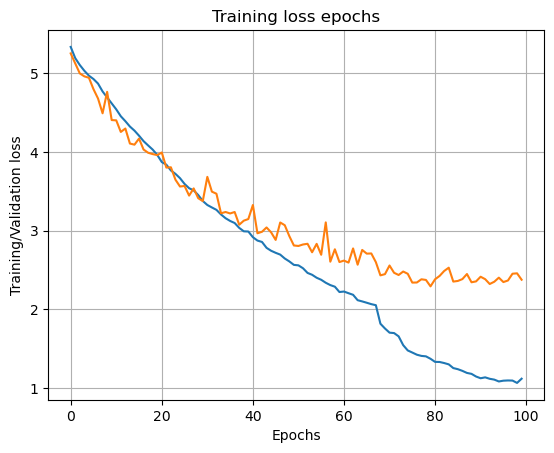

In [10]:
# I looked up how to bold words so I could make test accuracy more visible in output
bold_start = "\033[1m"
bold_end = "\033[0m"


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_transform = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
])

transform = transforms.Compose(
    [transforms.Resize((448, 448)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])])


batch_size = 32
epochs = 100
num_classes = 200

def create_list_of_epochs(epochs):
    list_of_epochs = []
    for epoch in range(epochs):
        list_of_epochs.append(epoch)
    return list_of_epochs


train_dataset = datasets.ImageFolder("CUB_200_2011_reorganized/train",
                                     transform=train_transform)
length_of_inital_train_dataset = int(0.95 * len(train_dataset))
length_of_validation_dataset = len(train_dataset) - length_of_inital_train_dataset
train_dataset, validation_dataset = random_split(
    train_dataset, [length_of_inital_train_dataset, length_of_validation_dataset])
validation_dataset.transform = transform
test_dataset = datasets.ImageFolder("CUB_200_2011_reorganized/test",
                                    transform=transform)

print(f"size of validation dataset {len(validation_dataset)}")

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
validation_loader = DataLoader(validation_dataset, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

#model = models.resnet34(weights=None)
model = MyNet()
#model = MACNN()
model = nn.DataParallel(model)
model = model.to(device)

loss_function = nn.CrossEntropyLoss()
# https://stackoverflow.com/questions/42704283/l1-l2-regularization-in-pytorch
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
validation_loss_tracker = []

list_of_training_loss = []

#model.summary()
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        prediction = model(images)
        loss = loss_function(prediction, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    training_loss_for_epoch = running_loss/len(train_dataset)
    list_of_training_loss.append(training_loss_for_epoch)

    model.eval()
    validation_loss = 0
    correct_for_validation = 0
    total_for_validation = 0
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_function(outputs, labels)
            validation_loss += loss.item() * images.size(0)
            nothing, predicted = torch.max(outputs.data, 1)
            total_for_validation += labels.size(0)
            correct_for_validation += (predicted == labels).sum().item()
    avg_val_loss = validation_loss / len(validation_dataset)
    validation_loss_tracker.append(avg_val_loss)
    accuracy = 100 * correct_for_validation / total_for_validation
    print(f"Epoch {epoch} Training Loss {training_loss_for_epoch}. Validation Loss {avg_val_loss} Accuracy {accuracy}")
    scheduler.step(avg_val_loss)


correct = 0
total = 0
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        model.eval()
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        nothing, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'{bold_start}Test Accuracy: {100 * correct // total} % {bold_end}')


list_of_epochs = create_list_of_epochs(epochs)

plt.xlabel("Epochs")
plt.ylabel("Training/Validation loss")
plt.title("Training loss epochs")
plt.plot(list_of_epochs, list_of_training_loss, label="Training Loss")
plt.plot(list_of_epochs, validation_loss_tracker, label="Validation loss")
plt.grid(True)
plt.show()
